In [1]:
%load_ext autoreload
%autoreload 2

import os
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch
import torch.nn as nn
from matplotlib import animation
from tqdm import tqdm

from dataset import SoccerDataset
from datatools.metrica_helper import MetricaHelper
from datatools.trace_animator import TraceAnimator
from datatools.trace_helper import TraceHelper
from models import load_model
from postprocessor import Postprocessor

### Evaluating a Direct GK Trajectory Regressor (DirectGK)

In [5]:
trial = 501
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)

model = load_model(params["model"], params).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
match_traces = pd.read_csv("data/metrica_traces/match3_test.csv", header=0)
helper = TraceHelper(match_traces)
helper.traces

In [10]:
if params["model"].startswith("macro"):
    macro_pred, micro_pred = helper.predict(model, target_type="gk", evaluate=True)
else:
    micro_pred = helper.predict(model, target_type="gk", evaluate=True)
    
micro_pred.dropna(axis=0, subset=micro_pred.columns[:-1], how="all")

Phase (3, 3) ('B01', 'A51'): 100%|██████████| 2/2 [00:16<00:00,  8.14s/it]


micro_acc: 0.2


,A02,A04,A06,A09,A10,A11,A13,A14,A15,A16,...,B24,B27,B64,B94,B99,B01,OUT-L,OUT-R,OUT-B,OUT-T
10,0.079341,0.084396,0.077526,0.007475,0.010902,0.025795,NaN,NaN,0.084977,NaN,...,0.006951,0.031088,0.034774,NaN,0.031180,0.044000,0.005213,0.007911,0.008712,0.006281
11,0.080801,0.084530,0.078122,0.007411,0.012042,0.026744,NaN,NaN,0.085210,NaN,...,0.006944,0.031039,0.034174,NaN,0.031058,0.037901,0.005178,0.007839,0.008628,0.006245
12,0.081528,0.084338,0.078401,0.007367,0.013685,0.027815,NaN,NaN,0.085067,NaN,...,0.007161,0.031068,0.033749,NaN,0.030919,0.033017,0.005133,0.007760,0.008538,0.006197
13,0.081646,0.083924,0.078465,0.007356,0.015973,0.029066,NaN,NaN,0.084675,NaN,...,0.007825,0.031306,0.033451,NaN,0.030980,0.029078,0.005082,0.007676,0.008443,0.006141
14,0.081226,0.083237,0.078260,0.007367,0.019277,0.030570,NaN,NaN,0.084001,NaN,...,0.008043,0.031957,0.033275,NaN,0.031538,0.027148,0.005021,0.007578,0.008334,0.006071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45321,NaN,0.004123,0.004196,0.004118,0.004175,0.330659,NaN,NaN,0.004129,0.355770,...,NaN,0.011052,NaN,0.004198,0.005114,0.010032,0.003258,0.004903,0.005792,0.003945
45322,NaN,0.004270,0.004343,0.004263,0.004345,0.335954,NaN,NaN,0.004278,0.343383,...,NaN,0.011389,NaN,0.004350,0.005327,0.009821,0.003376,0.005078,0.006084,0.004101
45323,NaN,0.004481,0.004550,0.004469,0.004586,0.342518,NaN,NaN,0.004490,0.325330,...,NaN,0.011909,NaN,0.004566,0.005625,0.009752,0.003543,0.005328,0.006488,0.004323
45324,NaN,0.004757,0.004821,0.004739,0.004905,0.348967,NaN,NaN,0.004768,0.302476,...,NaN,0.012636,NaN,0.004851,0.006015,0.009806,0.003764,0.005656,0.007017,0.004617


In [ ]:
i0 = 0
i1 = 1200

pred_poss = macro_pred.loc[i0:i1] if params["model"].startswith("macro") else None
anim = TraceHelper.plot_scene(
    match_traces.loc[i0:i1], 
    micro_pred.loc[i0:i1],
    pred_poss=pred_poss,
    show_episodes=True,
    show_events=True,
    play_speed=2
)
writer = animation.FFMpegWriter(fps=10)
path = f"animations/{trial}_fr{i0}-{i1}.mp4"
anim.save(path, writer=writer)

In [4]:
paths = ["data/metrica_traces/match3_test.csv"]
macro_type = params["macro_type"] if "macro_type" in params.keys() else None
dataset = SoccerDataset(paths, target_type="gk", macro_type=macro_type, n_features=params["n_features"], train=False)
len(dataset)

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


18058

### Evaluating a Direct Ball Trajectory Regressor (DirectBall)

##### (1) Load the trained model

In [2]:
trial = 802
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)
    if "dropout" not in params:
        params["dropout"] = 0
    if "speed_loss" not in params:
        params["speed_loss"] = False

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)
model = load_model(params["model"], params).to(device)
model.load_state_dict(state_dict)

params

{'dataset': 'soccer',
 'model': 'macro_pe_lstm',
 'target_type': 'ball',
 'macro_type': 'player_poss',
 'macro_weight': 50.0,
 'phys_weight': 0,
 'speed_loss': False,
 'prev_out_aware': False,
 'bidirectional': True,
 'flip_pitch': True,
 'n_features': 6,
 'batch_size': 896,
 'start_lr': 0.0005,
 'min_lr': 1e-05,
 'seed': 100,
 'cuda': True,
 'best_loss': 0,
 'type_aware': False,
 'pred_delta': False,
 'fix_dec_std': False,
 'normalize': True,
 'n_players': 11,
 'macro_embed_dim': 4,
 'macro_rnn_dim': 32,
 'micro_embed_dim': 128,
 'micro_rnn_dim': 256,
 'n_layers': 2,
 'dropout': 0,
 'total_params': 4983722}

##### (2) Testing the model with a sample window

In [2]:
macro_type = params["macro_type"] if params["model"].startswith("macro") else None
dataset = SoccerDataset(
    data_paths=["data/gps_event_traces_gk_pred/22213-22216.csv"],
    target_type="ball",
    macro_type=macro_type,
    train=False,
    n_features=params["n_features"],
    target_speed=params["speed_loss"],
    flip_pitch=True,
)
len(dataset)

NameError: name 'params' is not defined

In [4]:
data = dataset[3000]
input_tensor = data[0]
if macro_type is None:
    micro_target_tensor = data[1]
else:
    macro_target_tensor = data[1]
    micro_target_tensor = data[2]

players = [f"{team}{i:02d}" for team in ["A", "B"] for i in np.arange(11) + 1]
if macro_type == "player_poss":
    macro_cols = players + ["OUT-L", "OUT-R", "OUT-B", "OUT-T"]
    input_cols = [f"{p}{t}" for p in macro_cols for t in dataset.feature_types]
else:
    macro_cols = ["A", "B"]
    input_cols = [f"{p}{t}" for p in players for t in dataset.feature_types]

output_cols = ["ball_x", "ball_y"]
if not params["speed_loss"]:
    target_cols = output_cols
else:
    target_cols = output_cols + ["ball_speed"]

input_traces = pd.DataFrame(input_tensor.numpy(), columns=input_cols)
target_traces = pd.DataFrame(micro_target_tensor.numpy(), columns=target_cols)
traces = pd.concat([input_traces, target_traces], axis=1)

if macro_type == "team_poss":
    traces[macro_type] = np.where(macro_target_tensor.numpy(), "B", "A")
elif macro_type == "player_poss":
    player_poss_dict = dict(zip(range(len(macro_cols)), macro_cols))
    traces[macro_type] = macro_target_tensor.numpy()
    traces[macro_type] = traces[macro_type].map(player_poss_dict)
    
traces.head()

,A01_x,A01_y,A01_vx,A01_vy,A01_speed,A01_accel,A02_x,A02_y,A02_vx,A02_vy,...,OUT-B_accel,OUT-T_x,OUT-T_y,OUT-T_vx,OUT-T_vy,OUT-T_speed,OUT-T_accel,ball_x,ball_y,player_poss
0,31.085899,11.663090,-0.208546,0.738629,0.767505,-0.309400,16.777502,38.894604,-0.210713,2.525007,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,26.953510,62.443039,A09
1,31.075569,11.726591,-0.064057,0.708038,0.710930,-0.174080,16.756840,39.138027,-0.128836,2.487015,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,27.377081,62.570042,A09
2,31.096231,11.800676,0.091751,0.682381,0.688522,-0.007603,16.756840,39.381451,-0.050571,2.447789,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,27.821312,62.686462,A09
3,31.116894,11.864178,0.243705,0.664125,0.707428,0.221989,16.756840,39.614288,0.026490,2.400915,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,28.265545,62.813465,A09
4,31.158216,11.927679,0.356888,0.646856,0.738777,0.416578,16.767170,39.857708,0.104755,2.400175,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,28.720108,62.919300,A09


In [14]:
with torch.no_grad():
    micro_pred_tensor = model.forward(input_tensor.unsqueeze(0).to(device)).squeeze(0).detach().cpu()

if macro_type is None:
    pred_poss = None
    pred_traces = pd.DataFrame(micro_pred_tensor.numpy(), columns=output_cols)

else:  # macro_type in ["team_poss", "player_poss"]
    macro_pred_tensor = micro_pred_tensor[:, :-2]
    micro_pred_tensor = micro_pred_tensor[:, -2:]
    pred_poss = pd.DataFrame(nn.Softmax(dim=-1)(macro_pred_tensor).numpy(), columns=macro_cols)
    pred_traces = pd.DataFrame(micro_pred_tensor.numpy(), columns=output_cols)

    if macro_type == "player_poss":
        argmax_idxs = np.argpartition(-pred_poss.values, range(3), axis=1)[:, :3]
        player_poss_top3 = pd.DataFrame(np.array(pred_poss.columns)[argmax_idxs])
        traces["player_poss_top3"] = player_poss_top3.apply(lambda x: x.tolist(), axis=1)
    
pred_traces.head()

,ball_x,ball_y
0,23.425848,54.530376
1,25.515669,56.267860
2,26.789484,57.293980
3,27.703875,58.044991
4,28.447063,58.662796


In [13]:
anim = TraceHelper.plot_scene(traces, pred_traces, pred_poss, show_times=False, annot_cols=["player_poss_top3"])
writer = animation.FFMpegWriter(fps=10)
path = f"animations/{trial}_test.mp4"
anim.save(path, writer=writer)

##### (3) Testing the model with an entire match

In [69]:
match_id = "22213-22216"
match_traces = pd.read_csv(f"data/gps_event_traces_gk_pred/{match_id}.csv", header=0, encoding="utf-8-sig")
helper = TraceHelper(match_traces)
helper.traces

,frame,session,time,phase,episode,team_poss,event_player,event_types,A02_x,A02_y,...,B01_x,B01_y,B01_vx,B01_vy,B01_speed,B01_accel,ball_x,ball_y,intent_x,intent_y
0,1,1,0.1,"(1, 1)",1,A,NaN,NaN,29.815190,-2.084963,...,96.422394,34.983829,0.0,0.0,0.0,-0.020367,51.830496,35.253859,51.830496,35.253859
1,2,1,0.2,"(1, 1)",1,A,NaN,NaN,29.825521,-2.074379,...,96.422394,34.983829,0.0,0.0,0.0,-0.011090,51.830496,35.253859,51.830496,35.253859
2,3,1,0.3,"(1, 1)",1,A,NaN,NaN,29.835852,-2.063795,...,96.422394,34.983829,0.0,0.0,0.0,0.005711,51.830496,35.253859,51.830496,35.253859
3,4,1,0.4,"(1, 1)",1,A,NaN,NaN,29.866845,-2.042628,...,96.422394,34.983829,0.0,0.0,0.0,0.030036,51.830496,35.253859,51.830496,35.253859
4,5,1,0.5,"(1, 1)",1,A,NaN,NaN,29.887507,-2.021461,...,96.422394,34.983829,0.0,0.0,0.0,0.061884,51.830496,35.253859,51.830496,35.253859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57430,57431,2,2891.2,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.295372,29.492550,76.159939,31.020432
57431,57432,2,2891.3,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,80.011514,29.874521,76.159939,31.020432
57432,57433,2,2891.4,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,78.727655,30.256491,76.159939,31.020432
57433,57434,2,2891.5,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77.443797,30.638462,76.159939,31.020432


In [14]:
macro_pred, micro_pred = helper.predict(model, split=True, evaluate=True)
micro_pred.dropna(axis=0, subset=micro_pred.columns[:-1], how="all")

Phase (3, 3): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

macro_acc: 0.9239
micro_pos_error: 6.6718


,ball_x,ball_y
0,35.498043,32.599121
1,35.498043,32.599121
2,35.498043,32.599121
3,35.498043,32.599121
4,35.498043,32.599121
...,...,...
46074,7.008096,42.673382
46075,7.008096,42.673382
46076,7.008096,42.673382
46077,7.008096,42.673382


In [67]:
cols = [c for c in helper.traces.columns if not c.startswith("ball") and not c.startswith("intent")]
helper.traces[cols]

,frame,session,time,phase,episode,team_poss,event_player,event_types,A02_x,A02_y,...,B99_vx,B99_vy,B99_speed,B99_accel,B01_x,B01_y,B01_vx,B01_vy,B01_speed,B01_accel
0,1,1,0.1,"(1, 1)",1,A,NaN,NaN,29.815190,-2.084963,...,0.163995,-0.718646,0.737121,-1.582206,96.422394,34.983829,0.0,0.0,0.0,-0.020367
1,2,1,0.2,"(1, 1)",1,A,NaN,NaN,29.825521,-2.074379,...,0.251556,-0.518373,0.576186,-0.929833,96.422394,34.983829,0.0,0.0,0.0,-0.011090
2,3,1,0.3,"(1, 1)",1,A,NaN,NaN,29.835852,-2.063795,...,0.327798,-0.334381,0.468255,-0.385885,96.422394,34.983829,0.0,0.0,0.0,0.005711
3,4,1,0.4,"(1, 1)",1,A,NaN,NaN,29.866845,-2.042628,...,0.392721,-0.166673,0.426626,0.049638,96.422394,34.983829,0.0,0.0,0.0,0.030036
4,5,1,0.5,"(1, 1)",1,A,NaN,NaN,29.887507,-2.021461,...,0.446327,-0.015246,0.446587,0.376738,96.422394,34.983829,0.0,0.0,0.0,0.061884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57430,57431,2,2891.2,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.542566,0.898937,1.785385,-1.216739,NaN,NaN,NaN,NaN,NaN,NaN
57431,57432,2,2891.3,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.474801,0.765421,1.661598,-1.104679,NaN,NaN,NaN,NaN,NaN,NaN
57432,57433,2,2891.4,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.393790,0.644241,1.535480,-0.971611,NaN,NaN,NaN,NaN,NaN,NaN
57433,57434,2,2891.5,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.299535,0.535395,1.405504,-0.817536,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
i0 = 0
i1 = 1200
traces = helper.traces[helper.traces["session"] == 1].reset_index(drop=True)[i0:i1]
pred_poss = macro_pred.loc[i0:i1] if params["model"].startswith("macro") else None
annot_cols = ["team_poss"] if params["model"].startswith("macro") and params["macro_type"] == "team_poss" else None

anim = TraceHelper.plot_scene(
    traces,
    pred_traces=micro_pred[i0:i1],
    pred_poss=pred_poss,
    show_episodes=True,
    show_events=True,
    annot_cols=annot_cols
)

t0 = traces["time"].iloc[0]
t1 = traces["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"
path = f"animations/gps_{match_id}_{t0_str}-{t1_str}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

### Evaluating a Direct Ball Trajectory Generator (DirectBall-VRNN) 

In [26]:
trial = 302
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)
    if "dropout" not in params:
        params["dropout"] = 0
    if "speed_loss" not in params:
        params["speed_loss"] = False

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)
model = load_model(params["model"], params).to(device)
model.eval()
model.load_state_dict(state_dict)

params

{'model': 'pi_vrnn',
 'macro_type': 'team_poss',
 'target_type': 'ball',
 'macro_weight': 50,
 'rloss_weight': 0,
 'speed_loss': False,
 'masking': 1,
 'prev_out_aware': False,
 'bidirectional': False,
 'flip_pitch': True,
 'n_features': 6,
 'batch_size': 1792,
 'start_lr': 0.0005,
 'min_lr': 1e-05,
 'seed': 100,
 'cuda': True,
 'best_loss': 0,
 'n_players': 11,
 'context_dim': 128,
 'rnn_h_dim': 256,
 'n_layers': 2,
 'dropout': 0.2,
 'vae_h_dim': 128,
 'vae_z_dim': 16,
 'fix_dec_std': False,
 'total_params': 3736772}

In [27]:
trace_dir = "metrica_traces"
match_id = "match3_test"

# trace_dir = "gps_event_traces_gk_pred"
# match_id = "18849-18850"

match_traces = pd.read_csv(f"data/{trace_dir}/{match_id}.csv", header=0, encoding="utf-8-sig")

if trace_dir == "metrica_traces":  # for Metrica data
    match_events = pd.read_csv(f"data/metrica_events/{match_id}.csv", header=0, encoding="utf-8-sig")
    helper = MetricaHelper(traces_preprocessed=match_traces, events=match_events)
else:  # for Fitogether's GPS-event data
    from private_src.gps_event_helper import GPSEventHelper
    helper = GPSEventHelper(match_traces)
    
helper.traces

,frame,session,time,phase,episode,team_poss,player_poss,event_player,event_type,A11_x,...,B34_speed,B34_accel,B35_x,B35_y,B35_vx,B35_vy,B35_speed,B35_accel,ball_x,ball_y
0,27865,2,2786.5,2,0,B,NaN,NaN,NaN,10.95336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.88876,35.96544
1,27866,2,2786.6,2,0,B,NaN,NaN,NaN,10.95336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.88876,35.96544
2,27867,2,2786.7,2,0,B,NaN,NaN,NaN,10.95336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.88876,35.96544
3,27868,2,2786.8,2,0,B,NaN,NaN,NaN,10.95336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.88876,35.96544
4,27869,2,2786.9,2,0,B,NaN,NaN,NaN,10.95336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.88876,35.96544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29634,57499,2,5749.9,11,0,B,NaN,NaN,NaN,12.95244,...,1.094074,0.587719,54.285768,39.629520,-0.099351,0.127735,0.161824,0.248942,96.34356,36.34920
29635,57500,2,5750.0,11,0,B,NaN,NaN,NaN,12.95244,...,1.133474,0.590661,54.278424,39.647016,-0.121033,0.131363,0.178620,0.220379,96.34356,36.34920
29636,57501,2,5750.1,11,0,B,NaN,NaN,NaN,12.95244,...,1.187187,0.564587,54.249264,39.628440,-0.144726,0.124005,0.190585,0.156859,96.34356,36.34920
29637,57502,2,5750.2,11,0,B,NaN,NaN,NaN,12.95244,...,1.262793,0.509497,54.225180,39.609576,-0.170430,0.105661,0.200526,0.058382,96.34356,36.34920


In [28]:
macro_pred, micro_pred, stats = helper.predict(model, masking_prob=1, split=False, evaluate=True)
micro_pred.round(4)

Phase 3: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]
Phase 4: 0it [00:00, ?it/s]
Phase 5: 0it [00:00, ?it/s]
Phase 11: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

micro_pos_error: 16.1186


,ball_x,ball_y
0,54.2111,34.4277
1,54.2111,34.4277
2,54.2111,34.4277
3,54.2111,34.4277
4,54.2111,34.4277
...,...,...
29634,76.2924,50.3044
29635,76.2924,50.3044
29636,76.2924,50.3044
29637,76.2924,50.3044


In [24]:
i0 = 300
i1 = 1500

traces = helper.traces[i0:i1]
pred_traces = micro_pred[i0:i1]

animator = TraceAnimator(
    trace_dict={"main": traces, "darkorange": pred_traces},
    show_episodes=True,
    show_events=False,
    annot_cols=["team_poss", "player_poss"]
)
anim = animator.run()

t0 = traces["time"].iloc[0]
t1 = traces["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"

if trace_dir == "metrica_traces":  # for Metrica data
    if match_id.startswith("match3"):
        match_id = "match3"
    path = f"animations/vrnn_metrica_{match_id}_{t0_str}-{t1_str}.mp4"
else:  # for Fitogether's GPS-event data
    path = f"animations/vrnn_gps_{match_id}_{t0_str}-{t1_str}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

### Evaluating a Hierarchical Ball Trajectory Regressor (Team-Ball or Player-Ball)

In [2]:
trial = 916
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)
    if "dropout" not in params:
        params["dropout"] = 0
    if "speed_loss" not in params:
        params["speed_loss"] = False

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best_pe.pt",
    map_location=lambda storage, _: storage,
)
model = load_model(params["model"], params).to(device)
model.eval()
model.load_state_dict(state_dict)

params

{'model': 'player_ball',
 'macro_type': 'player_poss',
 'target_type': 'ball',
 'macro_weight': 20.0,
 'rloss_weight': 1.0,
 'speed_loss': False,
 'masking': 0.8,
 'prev_out_aware': False,
 'bidirectional': True,
 'flip_pitch': True,
 'n_features': 6,
 'batch_size': 224,
 'start_lr': 0.0001,
 'min_lr': 1e-05,
 'seed': 100,
 'cuda': True,
 'best_total_loss': 47.0,
 'best_pos_error': 4.52,
 'n_players': 11,
 'macro_ppe': False,
 'macro_fpe': True,
 'macro_fpi': True,
 'macro_pe_dim': 16,
 'macro_pi_dim': 16,
 'macro_rnn_dim': 256,
 'micro_pi_dim': 128,
 'micro_rnn_dim': 256,
 'dropout': 0.2,
 'total_params': 7723814}

In [3]:
trace_paths = [
    "data/gps_event_traces_gk_pred/20862-20875.csv",
    "data/gps_event_traces_gk_pred/21689-21704.csv",
    "data/gps_event_traces_gk_pred/22213-22216.csv",
    "data/metrica_traces/match3_test.csv"
]
if len(trace_paths) > 0:
    from private_src.gps_event_helper import GPSEventHelper

n_frames = 0
correct_team_poss = 0
correct_player_poss = 0
sum_pos_error = 0
sum_real_loss = 0

for path in trace_paths:
    print()
    print(path)
    match_traces = pd.read_csv(path, header=0, encoding="utf-8-sig")
    
    if path.split("/")[1] == "gps_event_traces_gk_pred":
        helper = GPSEventHelper(match_traces)
    else:
        match_events = pd.read_csv(f"data/metrica_events/match3_test.csv", header=0, encoding="utf-8-sig")
        helper = MetricaHelper(traces_preprocessed=match_traces, events=match_events)
    
    macro_pred, micro_pred, stats = helper.predict(model, masking_prob=1, split=False, evaluate=True)
    
    n_frames += stats["n_frames"]
    correct_team_poss += stats["correct_team_poss"]
    correct_player_poss += stats["correct_player_poss"]
    sum_pos_error += stats["sum_pos_error"]
    sum_real_loss += stats["sum_real_loss"]

print()
print("Total Performance:")
print(f"team_poss_acc: {round(correct_team_poss / n_frames, 4)}")
print(f"player_poss_acc: {round(correct_player_poss / n_frames, 4)}")
print(f"pos_error: {round(sum_pos_error / n_frames, 4)}")
print(f"real_loss: {round(sum_real_loss / n_frames, 4)}")


data/gps_event_traces_gk_pred/20862-20875.csv


Phase (2, 2): 100%|██████████| 14/14 [00:00<00:00, 14.92it/s]


team_poss_acc: 0.7092
player_poss_acc: 0.4902
pos_error: 4.2256
real_loss: 0.1956

data/gps_event_traces_gk_pred/21689-21704.csv


Phase (4, 3): 100%|██████████| 10/10 [00:00<00:00, 12.44it/s]


team_poss_acc: 0.75
player_poss_acc: 0.5155
pos_error: 4.7791
real_loss: 0.2048

data/gps_event_traces_gk_pred/22213-22216.csv


Phase (3, 3): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


team_poss_acc: 0.7526
player_poss_acc: 0.5248
pos_error: 5.1267
real_loss: 0.2213

data/metrica_traces/match3_test.csv


Phase 3: 100%|██████████| 2/2 [00:00<00:00, 13.20it/s]
Phase 4: 0it [00:00, ?it/s]
Phase 5: 0it [00:00, ?it/s]
Phase 11: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s]

team_poss_acc: 0.7702
player_poss_acc: 0.5222
pos_error: 4.609
real_loss: 0.2084

Total Performance:
team_poss_acc: 0.745
player_poss_acc: 0.5127
pos_error: 4.6658
real_loss: 0.2072


In [7]:
# trace_dir = "metrica_traces"
# match_id = "match3_test"

trace_dir = "gps_event_traces_gk_pred"
match_id = "20862-20875"

match_traces = pd.read_csv(f"data/{trace_dir}/{match_id}.csv", header=0, encoding="utf-8-sig")

if trace_dir == "metrica_traces":  # for Metrica data
    match_events = pd.read_csv(f"data/metrica_events/{match_id}.csv", header=0, encoding="utf-8-sig")
    helper = MetricaHelper(traces_preprocessed=match_traces, events=match_events)
else:  # for Fitogether's GPS-event data
    from private_src.gps_event_helper import GPSEventHelper
    helper = GPSEventHelper(match_traces)
    
helper.traces

,frame,session,time,phase,episode,team_poss,event_player,event_types,A02_x,A02_y,...,B13_y,B13_vx,B13_vy,B13_speed,B13_accel,ball_x,ball_y,intent_x,intent_y,player_poss
0,1,1,0.1,"(1, 1)",1,B,NaN,NaN,66.663498,53.794781,...,36.166523,0.0,0.0,0.0,-0.000780,53.664412,33.883963,53.664412,33.883963,NaN
1,2,1,0.2,"(1, 1)",1,B,NaN,NaN,66.673369,53.776539,...,36.166523,0.0,0.0,0.0,-0.006000,53.664412,33.883963,53.664412,33.883963,NaN
2,3,1,0.3,"(1, 1)",1,B,NaN,NaN,66.673369,53.749177,...,36.166523,0.0,0.0,0.0,-0.002991,53.664412,33.883963,53.664412,33.883963,NaN
3,4,1,0.4,"(1, 1)",1,B,NaN,NaN,66.683239,53.721814,...,36.166523,0.0,0.0,0.0,0.008249,53.664412,33.883963,53.664412,33.883963,NaN
4,5,1,0.5,"(1, 1)",1,B,NaN,NaN,66.693109,53.694451,...,36.166523,0.0,0.0,0.0,0.027718,53.664412,33.883963,53.664412,33.883963,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58910,58911,2,3062.1,"(4, 5)",101,B,NaN,NaN,34.190459,37.322523,...,NaN,NaN,NaN,NaN,NaN,57.560684,55.219914,58.885761,58.893337,NaN
58911,58912,2,3062.2,"(4, 5)",101,B,NaN,NaN,34.160848,37.422853,...,NaN,NaN,NaN,NaN,NaN,57.891953,56.138270,58.885761,58.893337,NaN
58912,58913,2,3062.3,"(4, 5)",101,B,NaN,NaN,34.111497,37.532303,...,NaN,NaN,NaN,NaN,NaN,58.223222,57.056625,58.885761,58.893337,NaN
58913,58914,2,3062.4,"(4, 5)",101,B,NaN,NaN,34.052276,37.659995,...,NaN,NaN,NaN,NaN,NaN,58.554492,57.974981,58.885761,58.893337,NaN


In [5]:
macro_pred, micro_pred, stats = helper.predict(model, masking_prob=1, split=False, evaluate=True)
macro_pred.round(4)

Phase 3: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]
Phase 4: 0it [00:00, ?it/s]
Phase 5: 0it [00:00, ?it/s]
Phase 11: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s]

team_poss_acc: 0.8724
player_poss_acc: 0.6089
pos_error: 4.1377
real_loss: 0.1538


,A11,A01,A02,A04,A05,A06,A07,A08,A10,A12,...,B30,B31,B32,B33,B34,B35,OUT-L,OUT-R,OUT-B,OUT-T
0,0.0001,0.0,0.0,0.0001,0.0,0.0,0.0001,0.0001,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0000
1,0.0001,0.0,0.0,0.0001,0.0,0.0,0.0001,0.0001,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0000
2,0.0001,0.0,0.0,0.0001,0.0,0.0,0.0001,0.0001,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0000
3,0.0001,0.0,0.0,0.0001,0.0,0.0,0.0001,0.0001,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0000
4,0.0001,0.0,0.0,0.0001,0.0,0.0,0.0001,0.0001,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29634,0.0000,0.0,NaN,0.0000,NaN,0.0,0.0000,NaN,NaN,0.0,...,0.0,0.0,0.0001,0.0017,0.9936,0.0,0.0,0.0,0.0,0.0004
29635,0.0000,0.0,NaN,0.0000,NaN,0.0,0.0000,NaN,NaN,0.0,...,0.0,0.0,0.0001,0.0017,0.9936,0.0,0.0,0.0,0.0,0.0004
29636,0.0000,0.0,NaN,0.0000,NaN,0.0,0.0000,NaN,NaN,0.0,...,0.0,0.0,0.0001,0.0017,0.9936,0.0,0.0,0.0,0.0,0.0004
29637,0.0000,0.0,NaN,0.0000,NaN,0.0,0.0000,NaN,NaN,0.0,...,0.0,0.0,0.0001,0.0017,0.9936,0.0,0.0,0.0,0.0,0.0004


In [14]:
argmax_idxs = np.argpartition(-macro_pred.values, range(3), axis=1)[:, :3]
player_poss_top3 = pd.DataFrame(np.array(macro_pred.columns)[argmax_idxs])
helper.traces["player_poss_top3"] = player_poss_top3.apply(lambda x: x.tolist(), axis=1)

### Acceleration-Based Postprocessing

In [8]:
pp = Postprocessor(helper.traces, macro_pred, micro_pred)
ep_traces, ep_pred_traces, players = pp.run(method="ball_accel", evaluate=True)
ep_traces

Phase (4, 2): 100%|██████████| 12/12 [00:00<00:00, 16.39it/s]


macro_acc: 0.452
micro_pos_error: 7.55


TypeError: cannot unpack non-iterable NoneType object

In [48]:
thres_accel = 5

accels = ep_pred_traces[["accel"]].copy()
for k in np.arange(2) + 1:
    accels[f"prev{k}"] = accels["accel"].shift(k, fill_value=0)
    accels[f"next{k}"] = accels["accel"].shift(-k, fill_value=0)

max_flags = (accels["accel"] == accels.max(axis=1)) & (accels["accel"] > thres_accel)
min_flags = (accels["accel"] == accels.min(axis=1)) & (accels["accel"] < -thres_accel)
max_idxs = accels[max_flags].index.tolist()
min_idxs = accels[min_flags].index.tolist()

if ep_traces.index[0] in max_idxs:
    max_idxs.pop(0)
if ep_traces.index[-1] in min_idxs:
    min_idxs.pop(-1)

if not min_idxs:
    min_idxs.insert(0, ep_traces.index[0])
if not max_idxs:
    max_idxs.append(ep_traces.index[-1])

if min_idxs[0] > max_idxs[0]:
    min_idxs.insert(0, ep_traces.index[0])
if min_idxs[-1] > max_idxs[-1]:
    max_idxs.append(ep_traces.index[-1])

max_idxs, min_idxs

([45370], [45340])

In [51]:
pp = Postprocessor(helper.traces, macro_pred, micro_pred)
pp.run(method="ball_accel", evaluate=True)
pp.output

Phase 6: 100%|██████████| 9/9 [00:00<00:00, 15.67it/s]

macro_acc: 0.4709
micro_pos_error: 2.5323


,carrier,ball_x,ball_y
0,NaN,42.996960,33.996960
1,B20,42.996960,33.996960
2,B20,43.078392,34.942752
3,B20,43.198596,36.260856
4,B20,43.211556,36.390672
...,...,...,...
56456,NaN,43.819233,0.000000
56457,NaN,43.819233,0.000000
56458,NaN,43.819233,0.000000
56459,NaN,43.819233,0.000000


In [ ]:
i0 = 0
i1 = 1200

animator = TraceAnimator(
    trace_dict={"main": pp.traces[i0:i1], "darkorange": pp.pred_traces[i0:i1], "green": pp.output_traces[i0:i1]},
    poss_probs=pp.pred_poss[i0:i1],
    show_episodes=True,
    show_events=True,
    annot_cols=["player_poss_top3", "carrier"]
)
anim = animator.run()

t0 = animator.trace_dict["main"]["time"].iloc[0]
t1 = animator.trace_dict["main"]["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"
path = f"animations/gps_{match_id}_{t0_str}-{t1_str}_pp.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

In [30]:
episode = 1
ep_traces = helper.traces[helper.traces["episode"] == episode].copy()
ep_pred_poss = macro_pred.loc[ep_traces.index].copy()
ep_pred_traces = micro_pred.loc[ep_traces.index].copy()
ep_pred_traces["time"] = ep_traces["time"]

players = [p for p in ep_pred_poss.dropna(axis=1) if not p.startswith("OUT")]
ep_pred_traces = Postprocessor.calc_ball_features(ep_pred_traces)
ep_carry_records, _ = Postprocessor.detect_carries_by_accel(ep_traces, ep_pred_traces, players)
ep_carry_records

,start_idx,end_idx,carrier
0,0,12,B24
1,22,31,B03
2,40,54,B88
3,63,68,B19
4,82,95,B20
5,113,165,B06
6,181,204,B20
7,230,283,B06
8,288,305,B88
9,318,324,B88


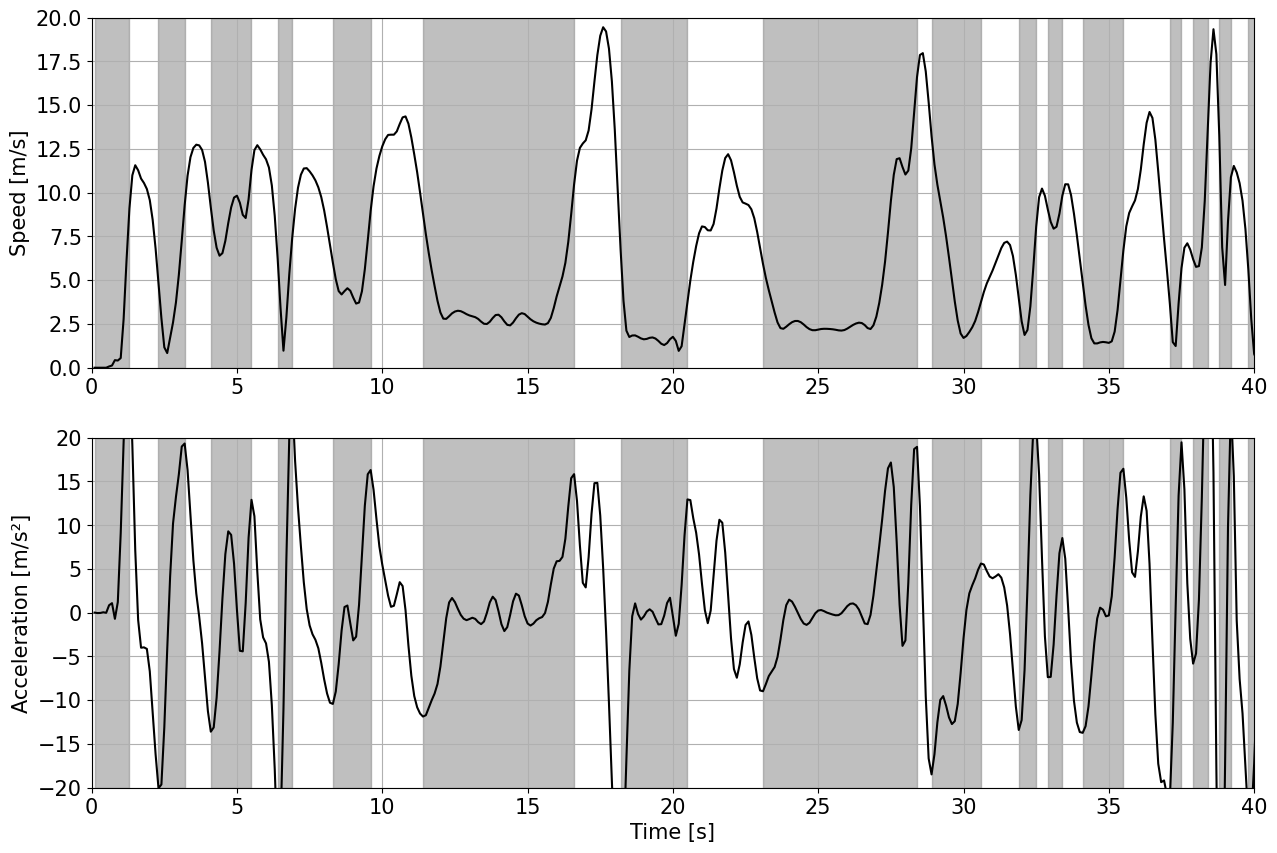

In [33]:
Postprocessor.plot_speeds_and_accels(ep_pred_traces, ep_carry_records)

### Possession Score-Based Postprocessing

In [15]:
pp = Postprocessor(helper.traces, macro_pred, micro_pred)
pp.run(method="poss_score", thres_touch=0.2, thres_carry=0.7, evaluate=True)
pp.output

100%|██████████| 8/8 [00:01<00:00,  4.30it/s]

macro_acc: 0.5698
micro_pos_error: 5.3142


,carrier,ball_x,ball_y,focus_x,focus_y
0,NaN,63.245124,37.517040,63.245124,37.517040
1,NaN,63.245124,37.517040,63.245124,37.517040
2,NaN,63.245124,37.517040,63.245124,37.517040
3,NaN,63.245124,37.517040,63.245124,37.517040
4,NaN,63.245124,37.517040,63.245124,37.517040
...,...,...,...,...,...
29634,NaN,96.458796,37.240704,96.458796,37.240704
29635,NaN,96.458796,37.240704,96.458796,37.240704
29636,NaN,96.458796,37.240704,96.458796,37.240704
29637,NaN,96.458796,37.240704,96.458796,37.240704


In [21]:
i0 = 0
i1 = 600

pp.traces["carrier"] = pp.output["carrier"]
traces = pp.traces[i0:i1]
pred_traces = pp.pred_traces[i0:i1]
pp_traces = pp.output[i0:i1]

animator = TraceAnimator(
    trace_dict={"main": traces, "darkorange": pred_traces, "green": pp_traces},
    poss_probs=pp.pred_poss[i0:i1],
    show_episodes=True,
    show_events=False,
    show_focus=True,
    annot_cols=["carrier", "player_poss_top3"]
)
anim = animator.run()

t0 = traces["time"].iloc[0]
t1 = traces["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"

if trace_dir == "metrica_traces":  # for Metrica data
    if match_id.startswith("match3"):
        match_id = "match3"
    path = f"animations/metrica_{match_id}_{t0_str}-{t1_str}.mp4"
else:  # for Fitogether's GPS-event data
    path = f"animations/gps_{match_id}_{t0_str}-{t1_str}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

In [7]:
episode = 36
ep_traces = pp.traces[pp.traces["episode"] == episode][:400].copy()
ep_poss_probs = macro_pred.loc[ep_traces.index].copy()
ep_poss_scores = pp.poss_scores.loc[ep_traces.index].copy()
ep_output = pp.output.loc[ep_traces.index].copy()

max_probs = ep_poss_probs.max()
valid_players = max_probs[max_probs > 0.2].index
valid_players

Index(['A04', 'B20', 'B21', 'B23', 'B24', 'B27', 'B29'], dtype='object')

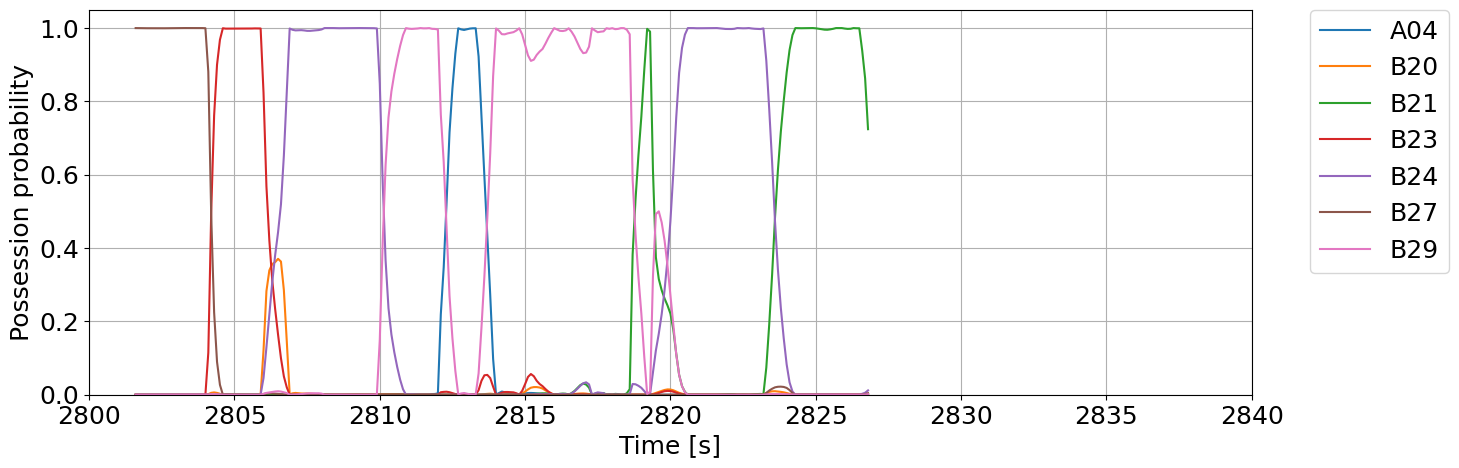

In [8]:
Postprocessor.plot_poss_values(ep_traces["time"], ep_poss_probs, valid_players, ylabel="Possession probability")

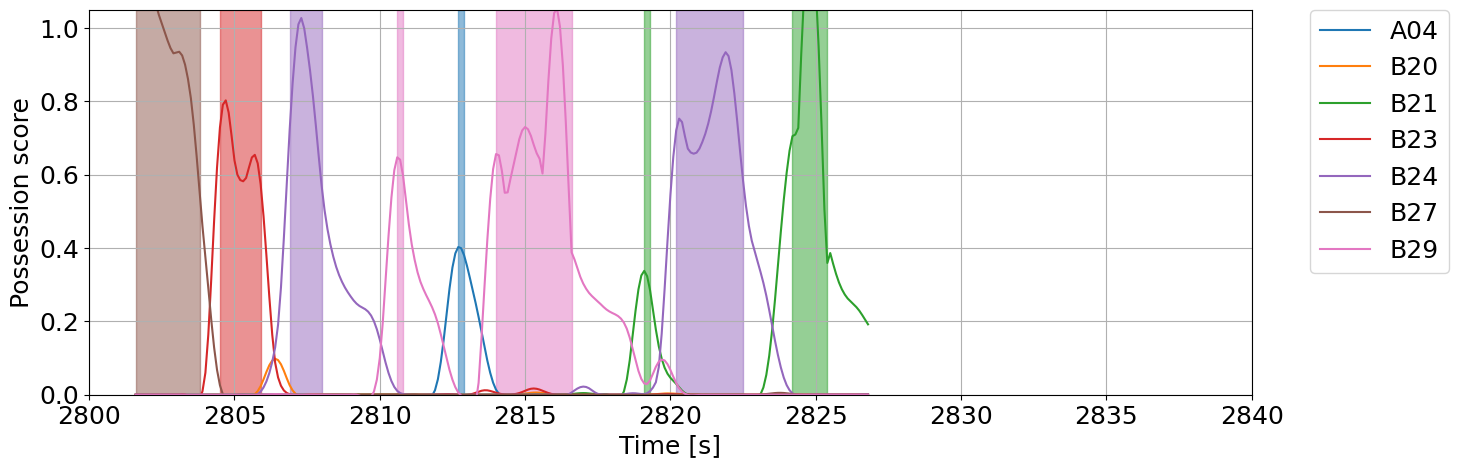

In [9]:
ep_carry_records = Postprocessor.generate_carry_records(ep_output["carrier"])
Postprocessor.plot_poss_values(ep_traces["time"], ep_poss_scores, valid_players, carry_records=ep_carry_records)

In [57]:
pp.traces["pred_ball_x"] = pp.output["focus_x"]
pp.traces["pred_ball_y"] = pp.output["focus_y"]
pp.traces[:3000].to_csv("data/18849-18850_results.csv", index=False)

### Evaluating the Pass Detection Accuracy

In [54]:
true_passes = helper.generate_pass_records(pp.traces["frame"])
true_passes

,episode,start_frame,end_frame,passer,receiver,success
0,1,21,35,B23,B20,True
1,1,59,75,B20,B18,True
2,1,100,114,B18,B17,True
3,1,127,139,B17,B16,True
4,1,158,170,B16,B15,True
...,...,...,...,...,...,...
1100,75,54922,54933,A01,A05,True
1101,75,54934,54944,A05,A01,True
1102,76,55300,55971,A03,B25,False
1103,77,56004,56024,B25,B21,True


In [55]:
pred_passes = []

for episode in tqdm(pp.traces["episode"].unique()):
    if episode == 0:
        continue

    ep_traces = pp.traces[pp.traces["episode"] == episode]
    ep_output = pp.output.loc[ep_traces.index]
    carry_records = Postprocessor.generate_carry_records(ep_output["carrier"])

    for i in carry_records.index[:-1]:
        start_frame = carry_records.at[i, "end_idx"] + 2
        end_frame = carry_records.at[i + 1, "start_idx"]
        passer = carry_records.at[i, "carrier"]
        receiver = carry_records.at[i + 1, "carrier"]
        if not receiver.startswith("OUT"):
            success = passer[0] == receiver[0]
            pred_passes.append([episode, start_frame, end_frame, passer, receiver, success])

pass_cols = ["episode", "start_frame", "end_frame", "passer", "receiver", "success"]
pred_passes = pd.DataFrame(pred_passes, columns=pass_cols)
pred_passes

100%|██████████| 78/78 [00:00<00:00, 254.00it/s]


,episode,start_frame,end_frame,passer,receiver,success
0,1,24,50,B23,B20,True
1,1,63,75,B20,B18,True
2,1,103,113,B18,B17,True
3,1,128,141,B17,B16,True
4,1,163,174,B16,B15,True
...,...,...,...,...,...,...
1150,75,54939,54953,A05,B20,False
1151,76,55305,55338,A03,B17,False
1152,77,55958,55974,A09,B25,False
1153,77,55998,56033,B25,B21,True


##### (1) Pass detection accuracy

In [56]:
true_count = 0
true_passes["true_pos"] = False
pred_passes["true_pos"] = False

for i in true_passes.index:
    t_min = true_passes.loc[i, "start_frame"] - 20
    t_max = true_passes.loc[i, "end_frame"] + 20
    passer = true_passes.loc[i, "passer"]
    receiver = true_passes.loc[i, "receiver"]

    candidates = pred_passes[(pred_passes["start_frame"] >= t_min) & (pred_passes["end_frame"] <= t_max)]
    matched = candidates[(candidates["passer"] == passer) & (candidates["receiver"] == receiver)]
    if not matched.empty:
        true_count += 1
        true_passes.at[i, "true_pos"] = True
        pred_passes.at[matched.index[0], "true_pos"] = True

precision = true_count / len(pred_passes)
recall = true_count / len(true_passes)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Matched passes: {true_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Matched passes: 942
Precision: 0.8156
Recall: 0.8525
F1 score: 0.8336


##### (2) Passer detection accuracy

In [57]:
true_count = 0

for i in true_passes.index:
    t_min = true_passes.loc[i, "start_frame"] - 20
    t_max = true_passes.loc[i, "end_frame"] + 20
    passer = true_passes.loc[i, "passer"]

    candidates = pred_passes[(pred_passes["start_frame"] >= t_min) & (pred_passes["end_frame"] <= t_max)]
    matched = candidates[candidates["passer"] == passer]
    if not matched.empty:
        true_count += 1

precision = true_count / len(pred_passes)
recall = true_count / len(true_passes)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Matched passes: {true_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Matched passes: 1027
Precision: 0.8892
Recall: 0.9294
F1 score: 0.9088


##### (3) Receiver detection accuracy

In [58]:
true_count = 0

for i in true_passes.index:
    t_min = true_passes.loc[i, "start_frame"] - 20
    t_max = true_passes.loc[i, "end_frame"] + 20
    receiver = true_passes.loc[i, "receiver"]

    candidates = pred_passes[(pred_passes["start_frame"] >= t_min) & (pred_passes["end_frame"] <= t_max)]
    matched = candidates[candidates["receiver"] == receiver]
    if not matched.empty:
        true_count += 1

precision = true_count / len(pred_passes)
recall = true_count / len(true_passes)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Matched passes: {true_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Matched passes: 1005
Precision: 0.8701
Recall: 0.9095
F1 score: 0.8894


##### (4) Comparing pass statistics

In [59]:
players = true_passes["passer"].unique()
players.sort()
pass_stats = pd.DataFrame(index=players)

pass_stats["true_passes"] = true_passes.groupby("passer")["start_frame"].count()
pass_stats["pred_passes"] = pred_passes.groupby("passer")["start_frame"].count()
pass_stats["true_receives"] = true_passes.groupby("receiver")["start_frame"].count()
pass_stats["pred_receives"] = pred_passes.groupby("receiver")["start_frame"].count()
display(pass_stats)

print(metrics.r2_score(pass_stats["true_passes"], pass_stats["pred_passes"]).round(4))
print(metrics.r2_score(pass_stats["true_receives"], pass_stats["pred_receives"]).round(4))

,true_passes,pred_passes,true_receives,pred_receives
A01,54,58,53,60
A02,36,37,38,38
A03,38,41,41,43
A04,69,73,70,73
A05,93,83,88,81
A06,81,83,74,83
A07,61,59,64,59
A08,54,59,54,58
A09,65,70,65,66
A10,19,19,23,23


0.9723
0.9649


### Archive to be Deleted

In [103]:
phase_traces = helper.traces[helper.traces["phase"] == "(1, 1)"]
player_x_cols = [f"{p}_x" for p in helper.team1_players + helper.team2_players]

poss_labels = [c[:3] for c in phase_traces[player_x_cols].dropna(axis=1).columns] + ["OUT-L", "OUT-R", "OUT-B", "OUT-T"]
poss_dict = dict(zip(poss_labels, range(len(poss_labels))))
poss_dict["GOAL-L"] = len(poss_labels) - 4
poss_dict["GOAL-R"] = len(poss_labels) - 3

poss_df = pd.DataFrame(index=phase_traces.index)
poss_df["time"] = phase_traces["time"]
poss_df["pred_1st"] = phase_traces["player_poss_top3"].apply(lambda x: poss_dict[x[0]])
poss_df["pred_2nd"] = phase_traces["player_poss_top3"].apply(lambda x: poss_dict[x[1]])
poss_df["pred_3rd"] = phase_traces["player_poss_top3"].apply(lambda x: poss_dict[x[2]])
target_poss = phase_traces["event_player"].fillna(method="bfill").fillna(method="ffill")
poss_df["target"] = target_poss.apply(lambda x: poss_dict[x])

poss_df

,time,pred_1st,pred_2nd,pred_3rd,target
0,0.1,0,1,2,17
1,0.2,0,1,2,17
2,0.3,0,1,2,17
3,0.4,0,1,2,17
4,0.5,0,1,2,17
...,...,...,...,...,...
28285,2828.6,14,18,3,18
28286,2828.7,14,18,3,18
28287,2828.8,14,18,3,18
28288,2828.9,14,18,3,18


In [104]:
FRAME_DUR = 10

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.rcParams.update({"font.size": 15})

ax.set(xlim=(0, FRAME_DUR), ylim=(-1, len(poss_labels)))
ax.grid(color="grey")
ax.set_xlabel("time")
ax.set_yticks(range(len(poss_labels)), poss_labels)

plots = []
plots.append(plt.plot(poss_df["time"], poss_df["pred_1st"], marker="s", color="darkblue", label="pred_1st")[0])
plots.append(plt.plot(poss_df["time"], poss_df["pred_2nd"], marker="o", color="blue", label="pred_2nd")[0])
plots.append(plt.plot(poss_df["time"], poss_df["pred_3rd"], marker="o", color="skyblue", label="pred_3rd")[0])
plots.append(plt.plot(poss_df["time"], poss_df["target"], marker="*", color="red", label="target")[0])
ax.legend()

def animate(i):
    ax.set_xlim(2 * i, 2 * i + FRAME_DUR)

frames = (9000 - 10 * FRAME_DUR) // 20 + 1
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=200)
plt.close(fig)

writer = animation.FFMpegWriter(fps=5)
path = f"animations/player_poss_plots.mp4"
anim.save(path, writer=writer)